## 分類器のパラメータ変化の挙動を調べる

 HWにあったコードの特にDecision Treeのパラメータを変化させてみて、  
その影響を図や決定木分類器のモデルの特徴などから考察してみる。

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

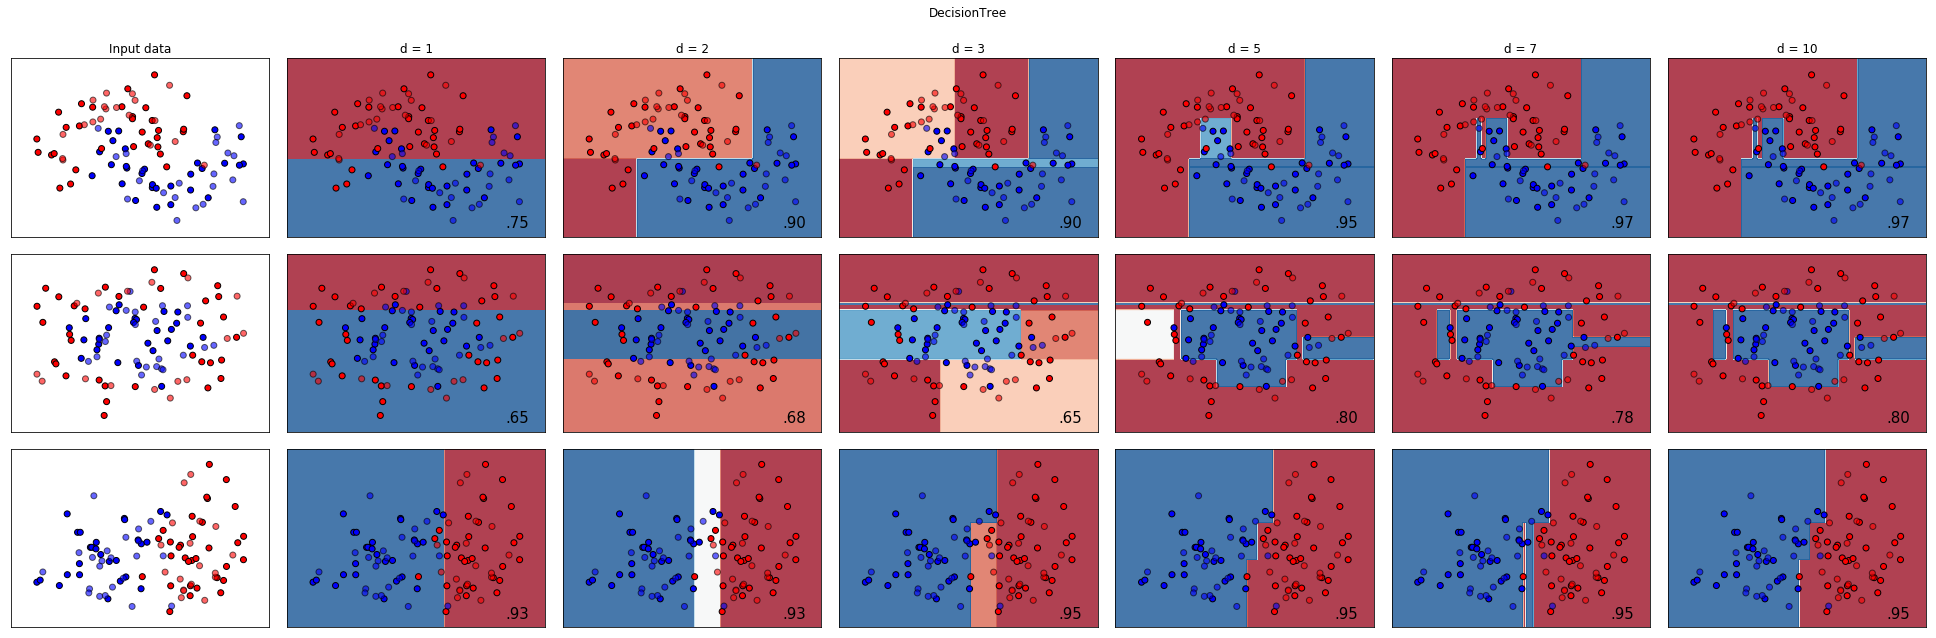

In [11]:
h = .02  # step size in the mesh

names = ["d = 1", "d = 2", "d = 3", "d = 5", "d = 7", "d = 10"]

classifiers = [
    DecisionTreeClassifier(max_depth=1),
    DecisionTreeClassifier(max_depth=2),
    DecisionTreeClassifier(max_depth=3),
    DecisionTreeClassifier(max_depth=5),
    DecisionTreeClassifier(max_depth=7),
    DecisionTreeClassifier(max_depth=10)]

X, y = make_classification(n_features=2, n_redundant=0, n_informative=2,
                           random_state=1, n_clusters_per_class=1)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

datasets = [make_moons(noise=0.3, random_state=0),
            make_circles(noise=0.2, factor=0.5, random_state=1),
            linearly_separable
            ]

figure = plt.figure(figsize=(27, 9))
i = 1
# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    X, y = ds
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=.4, random_state=42)

    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data")
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
               edgecolors='k')
    # Plot the testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6,
               edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)

        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, x_max]x[y_min, y_max].
        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

        # Plot the training points
        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
                   edgecolors='k')
        # Plot the testing points
        ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
                   edgecolors='k', alpha=0.6)

        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name)
        ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
                size=15, horizontalalignment='right')
        i += 1
figure.suptitle('DecisionTree')
plt.tight_layout()
figure.subplots_adjust(top = .9)
plt.show()

## 考察や学習したことのまとめ

 決定木は訓練データからテストデータの点がどちらのクラスに属するかを判定するためのYes,Noの質問文を学習していくモデルである。  
 特徴空間においては例えば「x_1 <= 0.4978 ?」のような質問をしてそれによってクラスを絞っていけるような質問文の木構造を学習する。  
 図を観察すると決定木による学習では特徴空間を矩形によって分割していることが読み取れるが、これは上で述べたYes,Noの質問文が特徴空間においては軸に平行な分割に対応しているからだと思われる。  
 depthパラメーターはすなわち質問文の決定木の深さそのもので、depth=1のときは質問が一回しか出来ないので図でも空間を1つの境界線が分割している。  
 以下では気づいたことや疑問点をまとめておきたい。  
 ・make_moon,linearly_separableではd=5がちょうど領域を"よく"分割しているように見える。  
 　（それ以上深さを増やすととても細い領域が出てきたりして過学習をしているように見える）
 ・make_circleの分割では分割領域もあまりきれいにならないし識別率もほか2つよdepth　　　　を上げても向上しない。(識別境界が常に軸に垂直になるので円の形のデータとは相性が悪い？)  
 ・make_moonではy座標がlinearly_separableではx座標成分が有効な属性になると見ることができるが、make_circleではx,y成分どちらも有効であるため属性数が多く決定木による表現に不向きなのであろうか？(なぜ有効な属性が多いと決定木は不利なのだろう)